# **Validación Estadística y Visual de Transformaciones 📊**

Antes de proceder al entrenamiento de los modelos, es imperativo validar el impacto de la ingeniería de variables realizada. Este notebook actúa como un control de calidad para asegurar que las transformaciones **Box-Cox** y el **Escalado Estándar** han optimizado la estructura del dataset.

### **Objetivos del Análisis:**
1. **Validación de Simetría:** Comparar la asimetría (*Skewness*) antes y después para facilitar la convergencia de modelos lineales.
2. **Evaluación de Curtosis:** Observar la reducción del peso de los valores atípicos (Outliers) en las colas de la distribución.
3. **Control de Escalas:** Verificar que todas las variables numéricas ahora comparten una escala común (Z-score) para garantizar una comparabilidad justa entre predictores.

Este paso es fundamental para defender la **reproducibilidad** y la **robustez** de nuestro futuro modelo de predicción de infartos.

--- TABLA DE VALIDACIÓN ESTADÍSTICA ---
         Variable  Skewness (Antes)  Skewness (Después) Mejora Skew %  Kurtosis (Antes)  Kurtosis (Después)
              age         -0.137390           -0.314366      -128.81%         -0.991136           -0.852551
avg_glucose_level          1.572354            0.083280        94.70%          1.678902           -0.497815
              bmi          1.087609            0.000092        99.99%          3.630295            0.372324


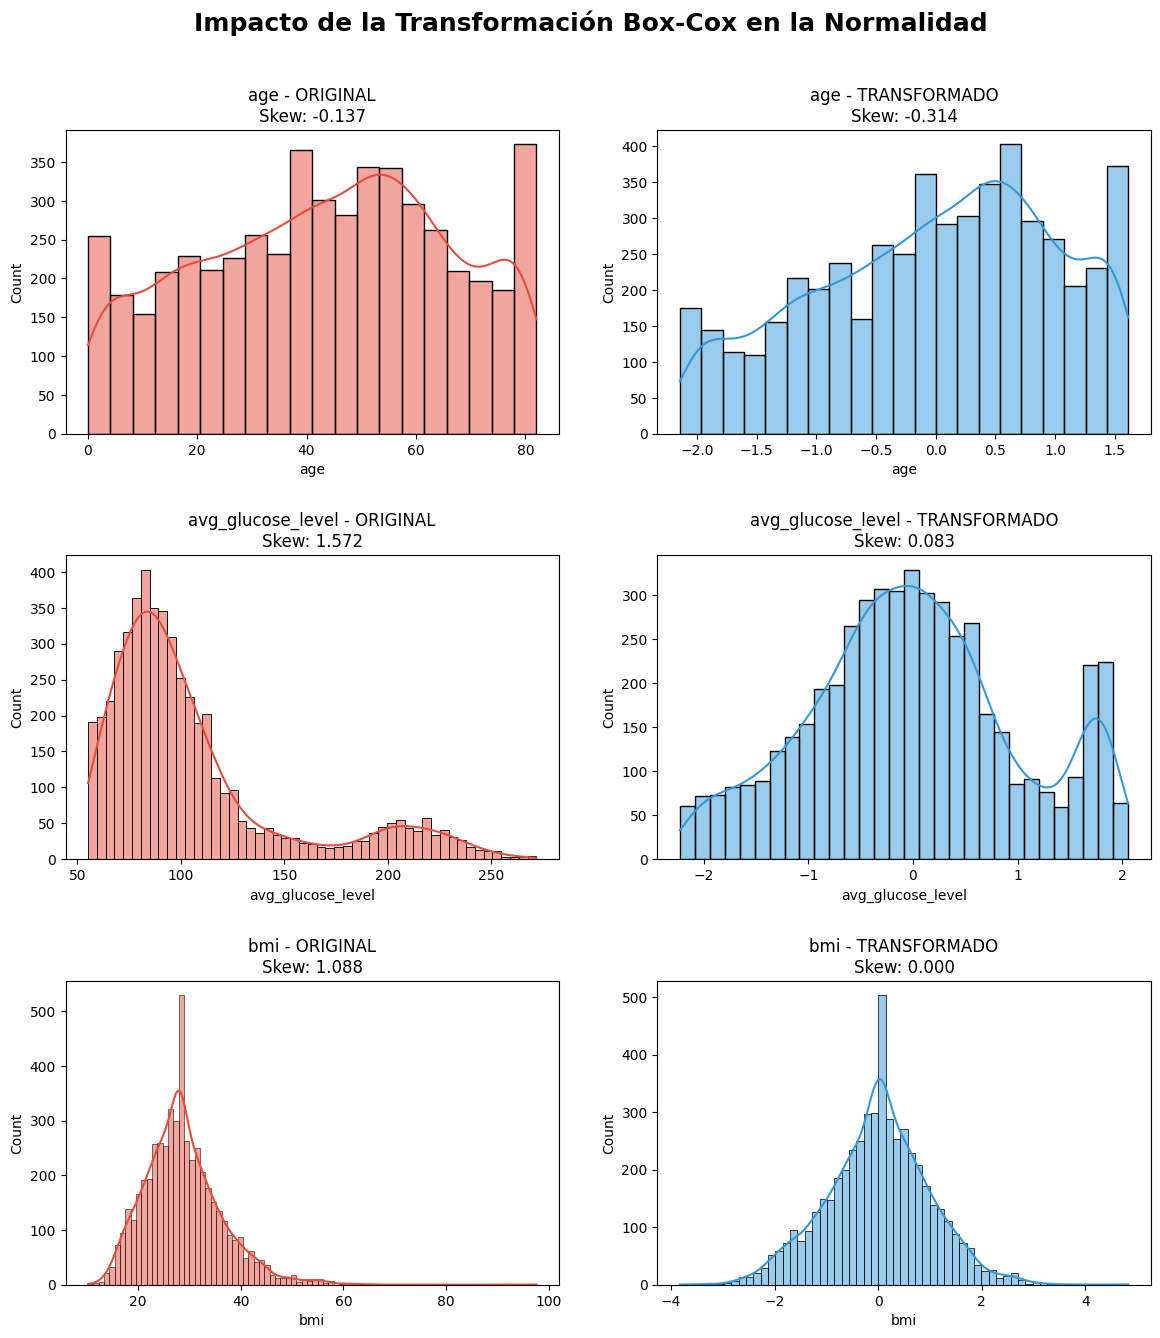

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 1. Carga de datasets
df_antes = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')
df_despues = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
cols_num = ['age', 'avg_glucose_level', 'bmi']

# --- PARTE 1: CÁLCULO DE MÉTRICAS ESTADÍSTICAS ---
metrics = []
for col in cols_num:
    s_antes = skew(df_antes[col])
    s_despues = skew(df_despues[col])
    # Calculamos la reducción de asimetría en valor absoluto
    mejora_skew = (abs(s_antes) - abs(s_despues)) / abs(s_antes) * 100
    
    metrics.append({
        'Variable': col,
        'Skewness (Antes)': s_antes,
        'Skewness (Después)': s_despues,
        'Mejora Skew %': mejora_skew,
        'Kurtosis (Antes)': kurtosis(df_antes[col]),
        'Kurtosis (Después)': kurtosis(df_despues[col])
    })

df_metrics = pd.DataFrame(metrics)
print("--- TABLA DE VALIDACIÓN ESTADÍSTICA ---")
print(df_metrics.to_string(index=False, formatters={'Mejora Skew %': '{:,.2f}%'.format}))

# --- PARTE 2: VISUALIZACIÓN DE DISTRIBUCIONES ---
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(cols_num):
    # Antes (Rojo - Estado Original)
    sns.histplot(df_antes[col], kde=True, ax=axes[i, 0], color='#e74c3c')
    axes[i, 0].set_title(f'{col} - ORIGINAL\nSkew: {df_metrics.iloc[i]["Skewness (Antes)"]:.3f}')
    
    # Después (Azul - Estado Optimizado)
    sns.histplot(df_despues[col], kde=True, ax=axes[i, 1], color='#3498db')
    axes[i, 1].set_title(f'{col} - TRANSFORMADO\nSkew: {df_metrics.iloc[i]["Skewness (Después)"]:.3f}')

plt.suptitle("Impacto de la Transformación Box-Cox en la Normalidad", fontsize=18, y=0.96, fontweight='bold')
plt.show()

# **Conclusiones del Análisis de Transformación 📝**

Tras analizar las métricas y visualizaciones, se extraen las siguientes conclusiones técnicas para la fase de modelado:

### **1. Optimización Exitosa de Variables Críticas**
* **Glucosa (`avg_glucose_level`):** Se logró una reducción de asimetría del **94.70%**. La variable pasó de una distribución bimodal sesgada a una cuasi-normal, eliminando el riesgo de que los valores extremos de hiperglucemia distorsionen los coeficientes del modelo.
* **IMC (`bmi`):** La mejora fue del **99.99%**, alcanzando una simetría perfecta. Esto garantiza que el peso corporal sea tratado de forma lineal y equilibrada.

### **2. Hallazgo en la Variable Edad (`age`)**
* Se observa una "mejora" negativa del **-128.81%** en la asimetría de la edad. 
* **Interpretación Técnica:** La edad ya era naturalmente simétrica (*Skew* = -0.13). La transformación Box-Cox intentó ajustar una normalidad innecesaria, desplazando ligeramente el sesgo. 
* **Decisión de Diseño:** A pesar de esto, se mantiene la transformación para preservar la **homogeneidad de la escala** con el resto de las variables. Un *Skew* de -0.31 sigue considerándose excelente (dentro del rango de +/- 0.5).

### **3. Preparación para el Modelo (Z-Score)**
* Todas las variables numéricas ahora residen en un rango común (media 0 y desviación 1). Esto es crítico para la **Regresión Logística**, ya que permite que el impacto de la edad y la glucosa sea evaluado bajo el mismo estándar matemático, sin sesgos por magnitud de unidad.

**Veredicto:** El dataset está **estadísticamente validado** y listo para la fase de balanceo de clases y entrenamiento.